## Importing modules

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import trange, tqdm

In [2]:
from utils.dataset import ClimateHackDataset
from utils.dataset_preprocessed import ClimatehackDatasetPreprocessed
from utils.loss import MS_SSIMLoss
from utils.utils import *
from utils.lr_finder import LRFinder
from config import config, results_config

from submission.ConvLSTM2 import ConvLSTM

In [3]:
device = torch.device(config['device'])
create_files(results_config.values())
save_logs(config, config['logs_path'])
device

device(type='cuda', index=0)

In [3]:
device = torch.device(config['device'])

#### Dataloader

In [4]:
dataset = xr.open_dataset(
    config['dataset_path'],
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

# train_dataset = ClimateHackDataset(dataset, crops_per_slice=1, day_limit=100)

# with open('D:\\climate_hack\\dataset.obj', 'rb') as file:
#     ch_dataset.cached_items = pickle.load(file)

# train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'])

In [5]:
train_dataset = ClimatehackDatasetPreprocessed(config['data_path'] + '\\train', config['data_path'] + '\\train_list.json')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=config['num_workers'], shuffle=True)

In [6]:
valid_dataset = ClimatehackDatasetPreprocessed(config['data_path'] + '\\valid', config['data_path'] + '\\valid_list.json')
valid_dataloader = DataLoader(valid_dataset, batch_size=config['batch_size'], num_workers=config['num_workers'], shuffle=False)

### Instantiating the model

In [4]:
# model = UNet(in_channels=12, out_channels=24, dim=2).to(device)
# model = EncoderDecoderConvLSTM(nf=32, encoder_channels=32).to(device)
# model = EncoderDecoderConvLSTM(nf=8).to(device)
# model = Model().to(device)
model = ConvLSTM().to(device)

NameError: name 'ConvLSTMBlockDecoder' is not defined

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = MS_SSIMLoss(channels=24) # produces less blurry images than nn.MSELoss()
# criterion = nn.MSELoss()

In [9]:
# lr_finder = LRFinder(model, optimizer, criterion)
# lr_finder.range_test(train_dataloader, end_lr=1, num_iter=500, start_lr=1e-6)
# lr_finder.plot()

In [10]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['num_epochs'], steps_per_epoch=(len(ch_dataset.cached_items)//config['batch_size'] + 1))

In [11]:
writer = SummaryWriter(config['tensorboard_path'])

odict_keys(['module.encoder.convlstm_0.conv.weight', 'module.encoder.down_1.downsample.0.filt', 'module.encoder.down_1.downsample.1.weight', 'module.encoder.down_1.downsample.2.weight', 'module.encoder.down_1.downsample.2.bias', 'module.encoder.down_1.downsample.2.running_mean', 'module.encoder.down_1.downsample.2.running_var', 'module.encoder.down_1.downsample.2.num_batches_tracked', 'module.encoder.down_1.conv1.weight', 'module.encoder.down_1.bn1.weight', 'module.encoder.down_1.bn1.bias', 'module.encoder.down_1.bn1.running_mean', 'module.encoder.down_1.bn1.running_var', 'module.encoder.down_1.bn1.num_batches_tracked', 'module.encoder.down_1.blur.filt', 'module.encoder.down_1.conv2.weight', 'module.encoder.down_1.bn2.weight', 'module.encoder.down_1.bn2.bias', 'module.encoder.down_1.bn2.running_mean', 'module.encoder.down_1.bn2.running_var', 'module.encoder.down_1.bn2.num_batches_tracked', 'module.encoder.convlstm_2.conv.weight', 'module.encoder.down_3.downsample.0.filt', 'module.encod

In [15]:
state_dict = {k.split('module.')[-1] : v for k, v in torch.load(r"C:\Users\bubur\Desktop\vm_uni\checkpoints\15.pt")['state_dict'].items()}

In [28]:
for k, v in state_dict.items():
    if 'num_batches_tracked' not in k:
        print(k, v.mean(), '...', v.min(), '...', v.max())

encoder.convlstm_0.conv.weight tensor(-0.0002) ... tensor(-0.1264) ... tensor(0.1292)
encoder.down_1.downsample.0.filt tensor(0.0625) ... tensor(0.0156) ... tensor(0.1406)
encoder.down_1.downsample.1.weight tensor(-0.0015) ... tensor(-0.2165) ... tensor(0.2084)
encoder.down_1.downsample.2.weight tensor(0.9580) ... tensor(0.7289) ... tensor(1.0381)
encoder.down_1.downsample.2.bias tensor(0.0041) ... tensor(-0.0449) ... tensor(0.0728)
encoder.down_1.downsample.2.running_mean tensor(-0.0014) ... tensor(-0.0118) ... tensor(0.0112)
encoder.down_1.downsample.2.running_var tensor(1.0861e-05) ... tensor(6.6225e-07) ... tensor(2.9085e-05)
encoder.down_1.conv1.weight tensor(0.0003) ... tensor(-0.1126) ... tensor(0.1088)
encoder.down_1.bn1.weight tensor(0.9423) ... tensor(0.7932) ... tensor(1.0153)
encoder.down_1.bn1.bias tensor(0.0044) ... tensor(-0.0588) ... tensor(0.0657)
encoder.down_1.bn1.running_mean tensor(-0.0009) ... tensor(-0.0496) ... tensor(0.0408)
encoder.down_1.bn1.running_var tenso

In [16]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
for p in model.parameters():
    print(p.mean())

tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7.0195e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0213, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0004, devi

### Training the model

In [17]:
train_batch = 0
valid_batch = 0

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14035 [00:00<?, ?it/s]

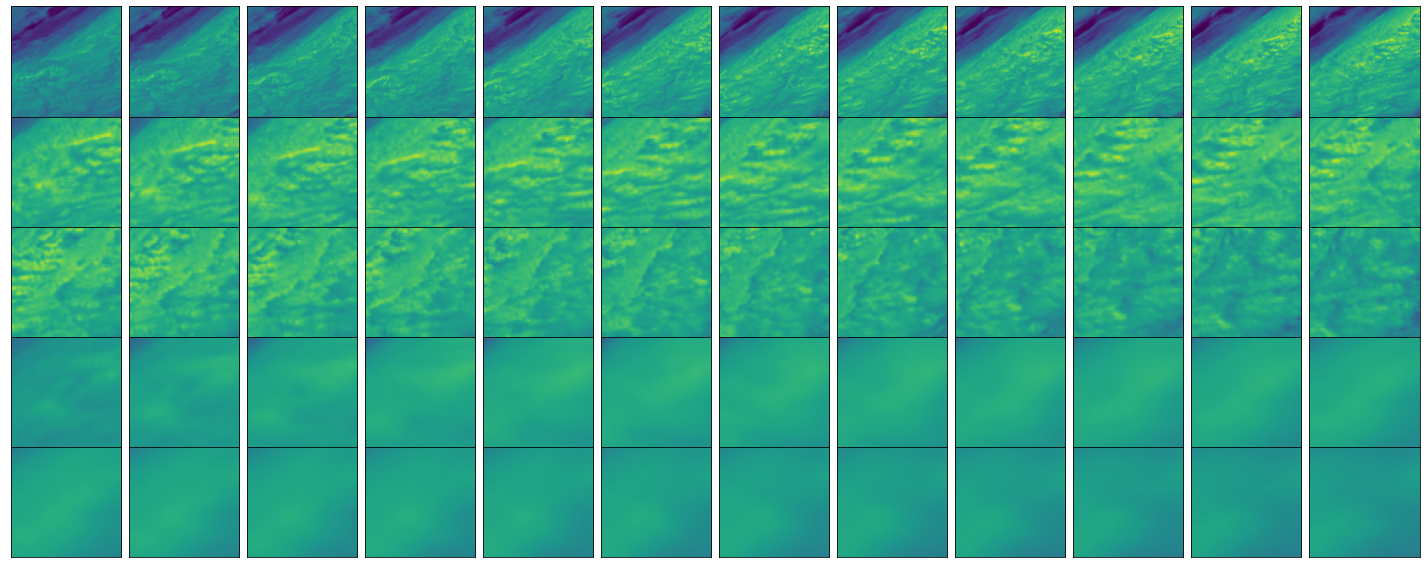

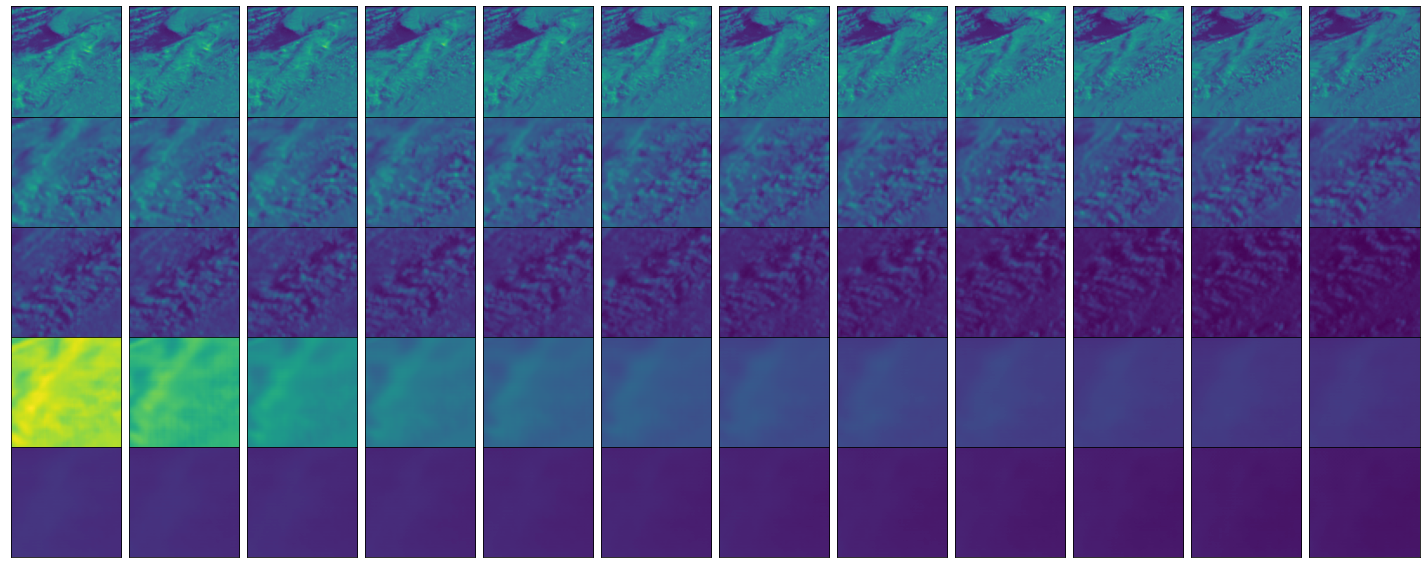

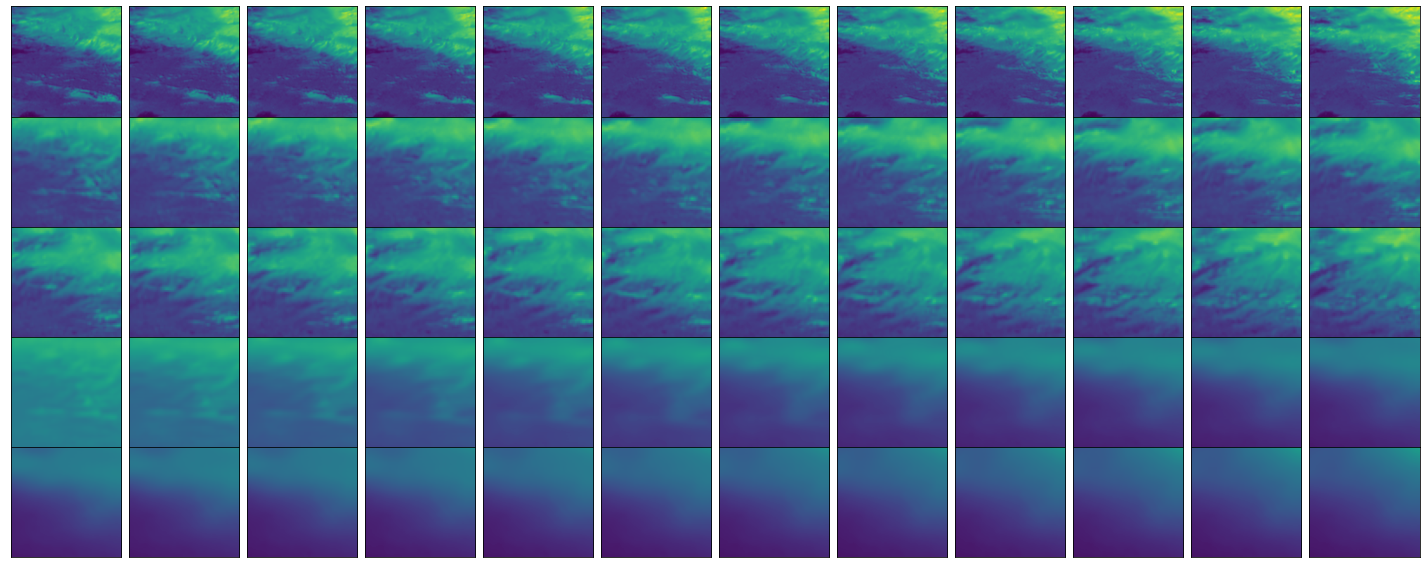

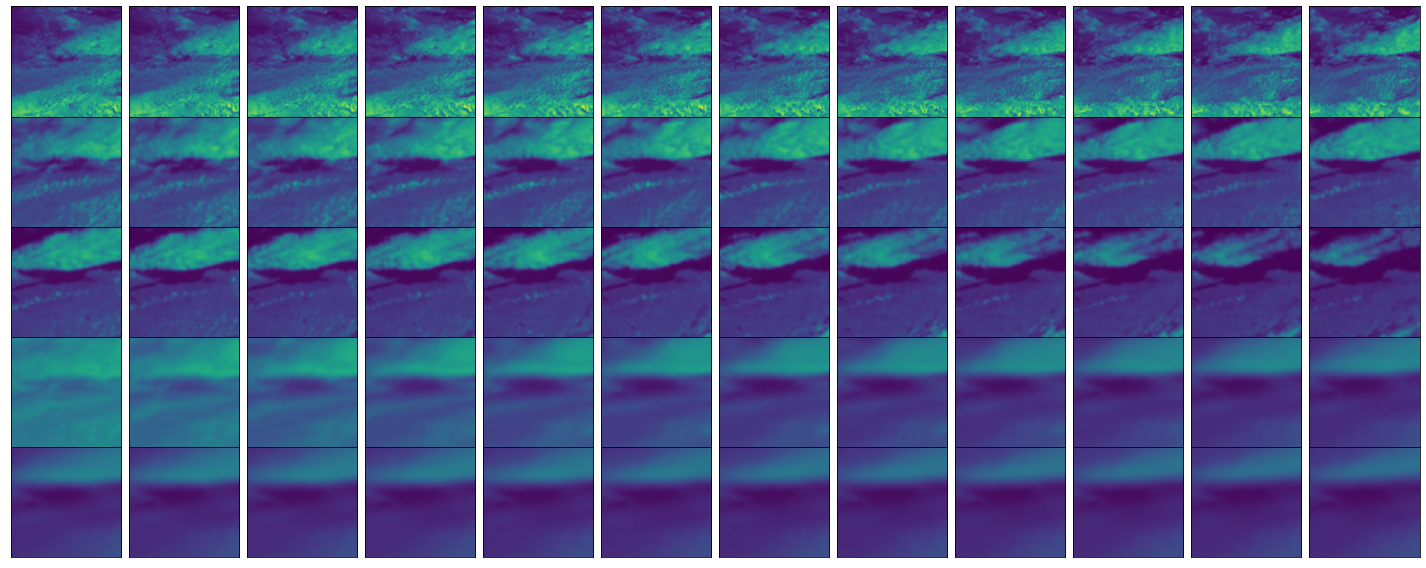

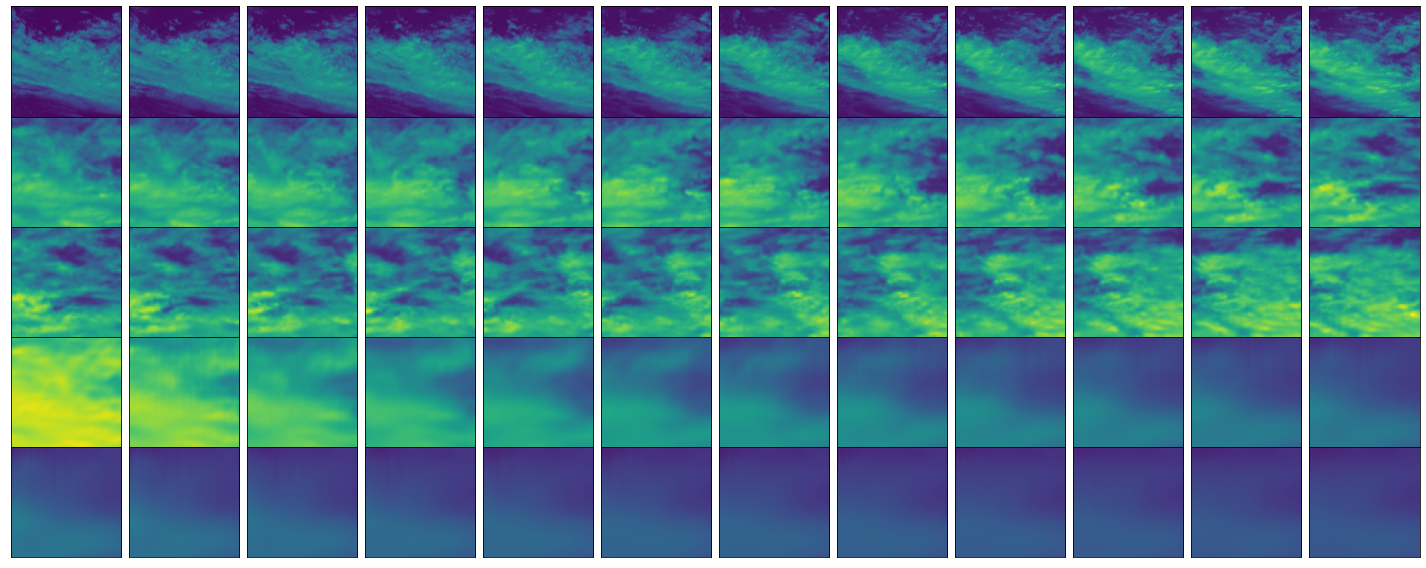

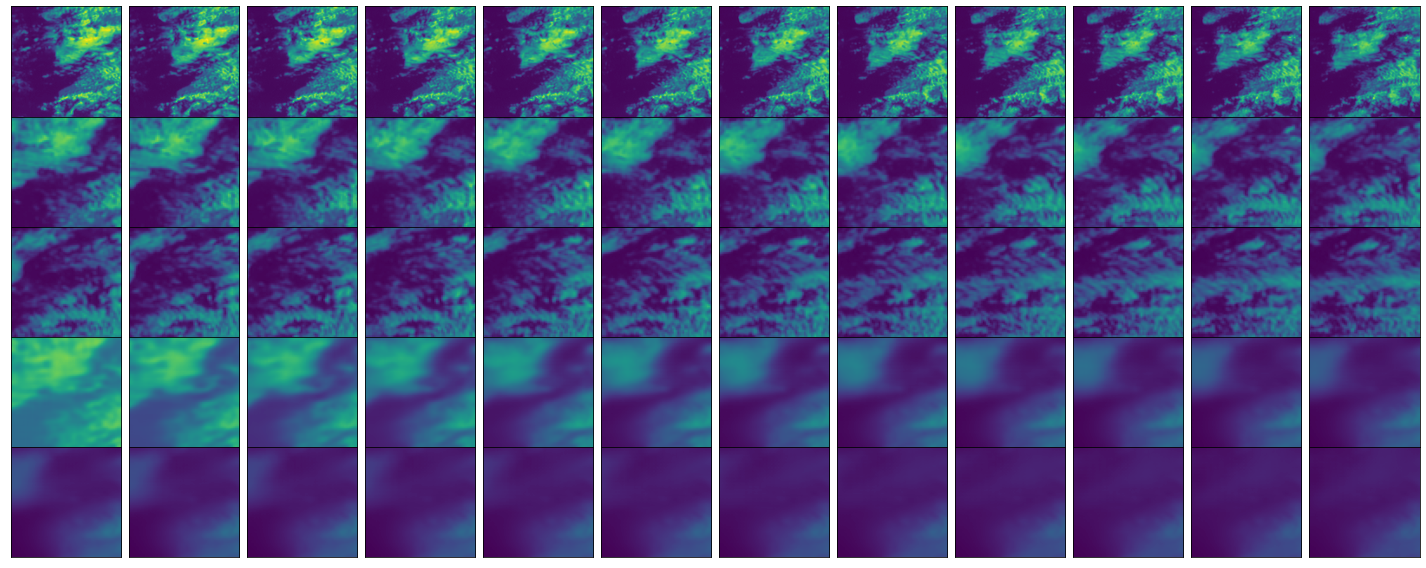

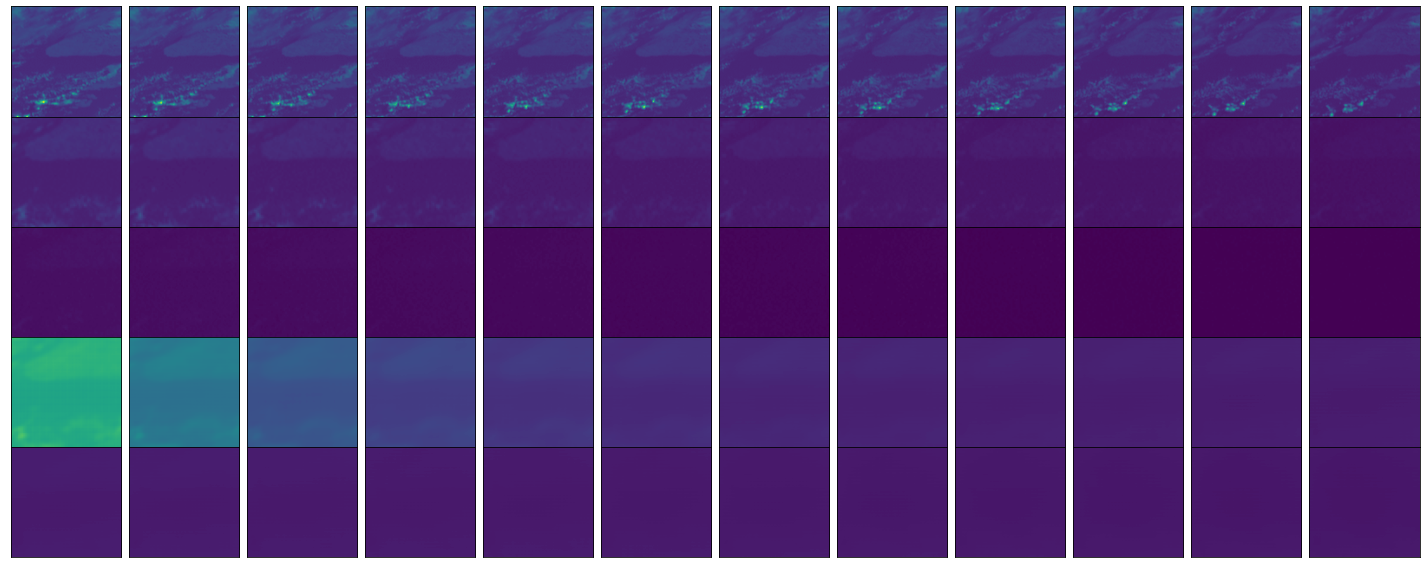

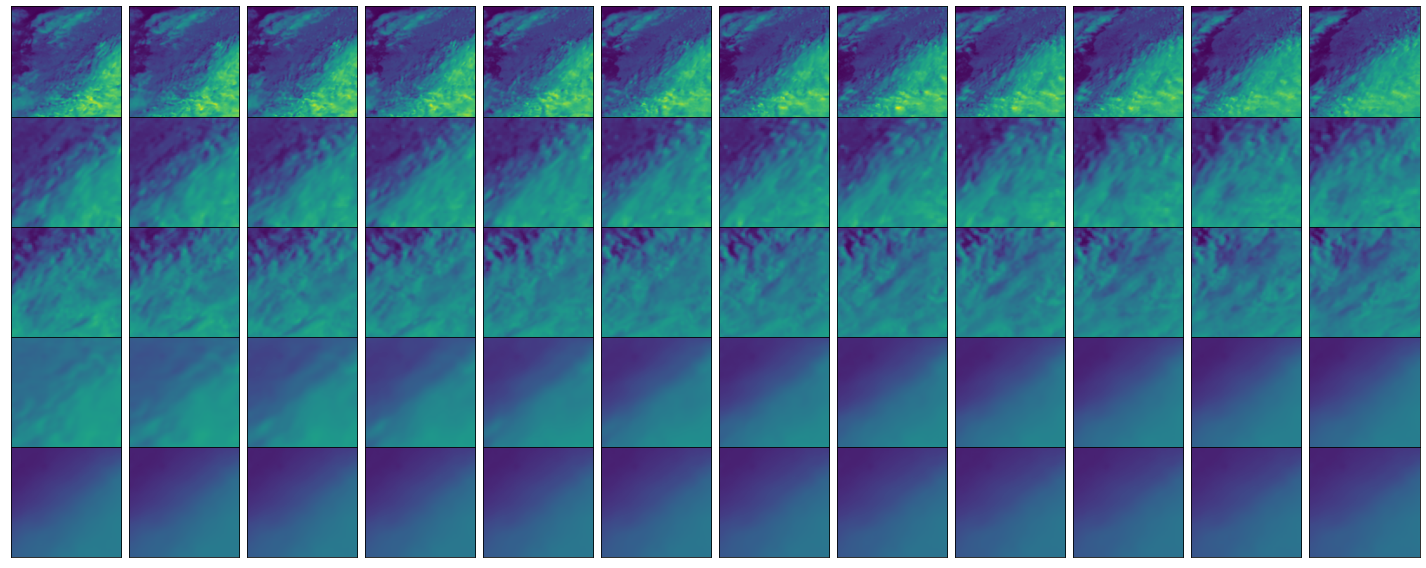

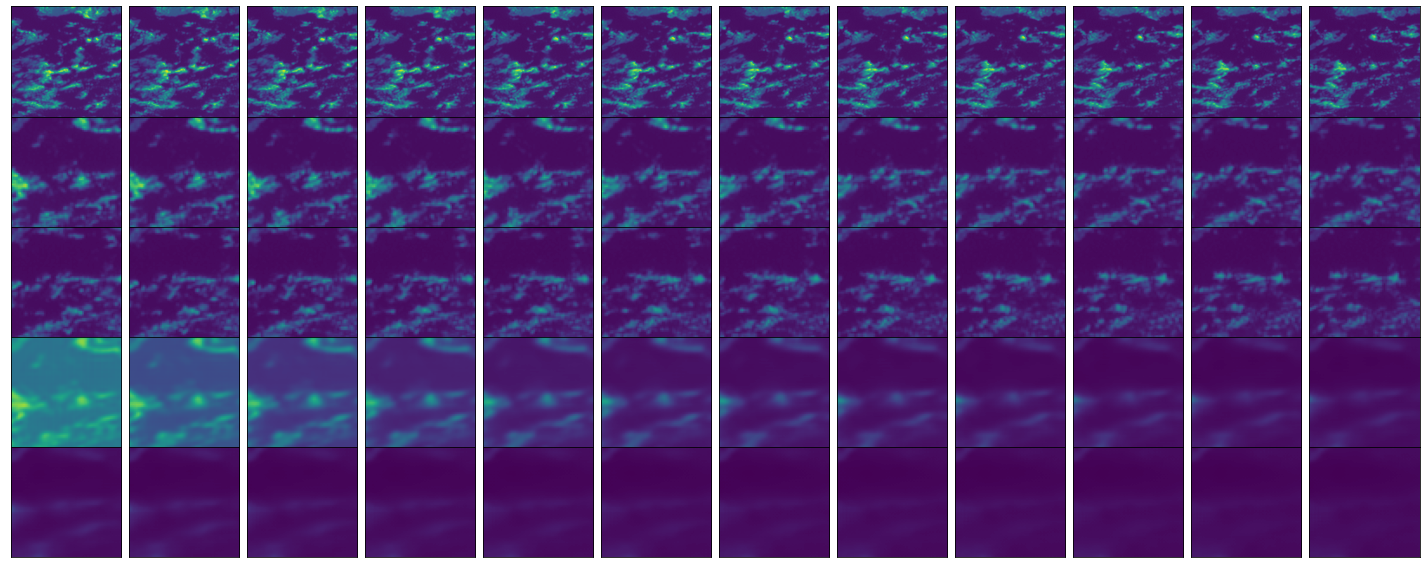

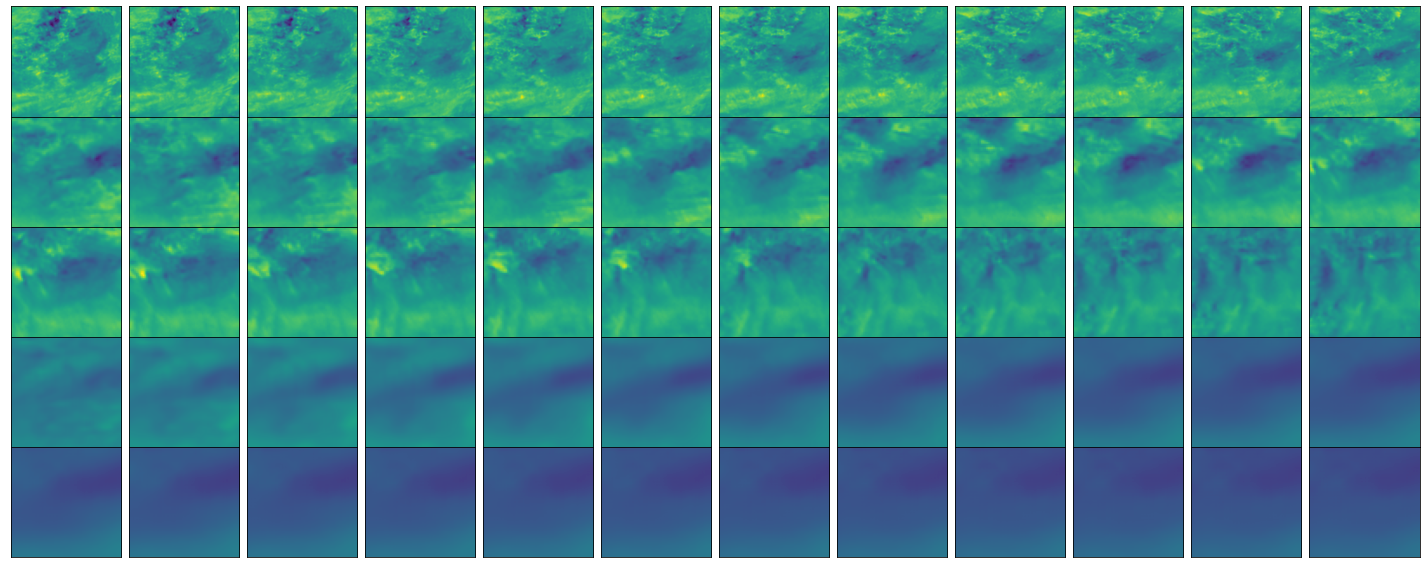

KeyboardInterrupt: 

In [19]:
for epoch in trange(config['num_epochs']):
#     """
#     Train
#     """
#     train_loss = 0
#     count = 0
#     model = model.train()

#     for inputs, target in tqdm(train_dataloader):
#         inputs = inputs.to(device)
#         target = target.to(device)
        
#         # clear gradients
#         optimizer.zero_grad()
        
#         # forward
#         output = model(inputs)
#         assert output.min() > 1 and output.max() <= 1024
#         assert target.min() > 1 and target.max() <= 1024
#         batch_loss = criterion(output, target)
        
#         # compute gradients
#         batch_loss.backward()
        
#         # update weights
#         optimizer.step()
        
#         # update stats
#         train_loss += batch_loss.item() * output.shape[0]
#         count += output.shape[0]

#         # writer.add_scalar('Train/loss', batch_loss.item(), train_batch)
#         writer.add_scalar('Train/lr', get_lr(optimizer), train_batch)
        
#         if train_batch % 1 == 0:
#             plot_preds(inputs.squeeze(2).detach().cpu().numpy()[0] * 1024,
#                        target.squeeze(2).detach().cpu().numpy()[0] ,
#                        output.squeeze(2).detach().cpu().numpy()[0])
            
#         train_batch += 1
        
#         # scheduler.step()

#         del inputs, target, output, batch_loss
#     print(train_loss / count)
#     writer.add_scalar('Train/loss', train_loss / count, epoch)
    
    
    """
    Valid
    """
    valid_loss = 0
    count = 0
    model.eval()

    with torch.no_grad():
        for inputs, target in tqdm(train_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)
            
            output = model(inputs)
            assert output.min() > 1 and output.max() <= 1024
            assert target.min() > 1 and target.max() <= 1024
            
            batch_loss = criterion(output, target)
            
            valid_loss += batch_loss.item() * output.shape[0]
            count += output.shape[0]
            
            if valid_batch % 1 == 0:
                plot_preds(inputs.squeeze(2).cpu().numpy()[0] * 1024,
                           target.squeeze(2).cpu().numpy()[0],
                           output.squeeze(2).cpu().numpy()[0])
                
            valid_batch += 1
            
            del inputs, target, output, batch_loss
    
    print(valid_loss / count)
    writer.add_scalar('Valid/loss', valid_loss / count, epoch)
    
    save_model(epoch, model, optimizer, config['checkpoints_path'])
    # print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

### Visualising predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

In [ ]:
config['checkpoints_path']

In [ ]:
# model.load_state_dict(torch.load('D:/climate_hack/results/conv_lstm_2d-decoder_mse/checkpoints/4.pt')['state_dict'])
model.load_state_dict(torch.load('submission/model_conv-lstm-unet_all-data.pt'))

In [ ]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()
x_ = torch.from_numpy(x.astype(np.float32)).to(device).view(1, 12, 1, 128, 128) / 1024
print(x_.shape)
p = model(x_).detach().squeeze().cpu().numpy()
# p = p * 1023.0

plot_preds(x, y, p)

In [ ]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()
x_ = torch.from_numpy(x.astype(np.float32)).to(device).view(1, 12, 1, 128, 128) / 1023
print(x_.shape)
p = model(x_).detach().squeeze().cpu().numpy()
# p = p * 1023.0

plot_preds(x, y, p)

In [ ]:
criterion(torch.Tensor(p).to(device).unsqueeze(0), torch.Tensor(y).to(device).unsqueeze(0))

In [ ]:
state_dict = model.state_dict()
    
for key in state_dict.keys():
    state_dict[key] = state_dict[key].cpu()

In [ ]:
torch.save(state_dict, 'submission/model.pt')

In [ ]:
model

In [ ]:
# with open('D:\\climate_hack\\dataset.obj', 'wb') as file:
#     pickle.dump(ch_dataset.cached_items, file)

#### Submitting the model to DOXA
```bash
$ python doxa_cli.py user login
```
```bash
$ python doxa_cli.py agent upload climatehack ./submission
```